In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


In [6]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs('../models/finetuned', exist_ok=True)

In [ ]:
print("\nLoading embeddings and labels...")

embeddings = np.load('../data/embeddings/embeddings.npy')
labels = np.load('../data/embeddings/labels.npy')

with open('../data/embeddings/metadata.json', 'r') as f:
    metadata = json.load(f)

class_names = metadata['class_names']
num_classes = len(class_names)

print(f"\n✓ Data loaded successfully!")
print(f"  Embeddings shape: {embeddings.shape}")
print(f"  Labels shape: {labels.shape}")
print(f"  Number of classes: {num_classes}")
print(f"  Classes: {class_names}")


Loading embeddings and labels...

✓ Data loaded successfully!
  Embeddings shape: (97, 1024)
  Labels shape: (97,)
  Number of classes: 4
  Classes: ['car_honk', 'cat', 'dog', 'police_siren']


In [8]:
print("\nSplitting data into train/validation/test sets...")

# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    embeddings, labels, test_size=0.15, random_state=42, stratify=labels
)

# Second split: separate train and validation (70% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print(f"\n✓ Data split complete!")
print(f"  Training samples: {len(X_train)} ({len(X_train)/len(embeddings)*100:.1f}%)")
print(f"  Validation samples: {len(X_val)} ({len(X_val)/len(embeddings)*100:.1f}%)")
print(f"  Test samples: {len(X_test)} ({len(X_test)/len(embeddings)*100:.1f}%)")

# Class distribution
print("\nClass distribution in training set:")
for idx, class_name in enumerate(class_names):
    count = np.sum(y_train == idx)
    print(f"  {class_name}: {count} ({count/len(y_train)*100:.1f}%)")



Splitting data into train/validation/test sets...

✓ Data split complete!
  Training samples: 67 (69.1%)
  Validation samples: 15 (15.5%)
  Test samples: 15 (15.5%)

Class distribution in training set:
  car_honk: 17 (25.4%)
  cat: 16 (23.9%)
  dog: 17 (25.4%)
  police_siren: 17 (25.4%)


In [9]:
def create_classification_model(input_dim=1024, num_classes=4, dropout_rate=0.3):
    """
    Create a simple MLP classifier on top of YAMNet embeddings
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        
        # Dense layers with dropout for regularization
        tf.keras.layers.Dense(256, activation='relu', name='dense_1'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        
        tf.keras.layers.Dense(128, activation='relu', name='dense_2'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        
        tf.keras.layers.Dense(64, activation='relu', name='dense_3'),
        tf.keras.layers.Dropout(dropout_rate),
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax', name='output')
    ], name='audio_classifier')
    
    return model

# Create model
model = create_classification_model(
    input_dim=embeddings.shape[1],
    num_classes=num_classes,
    dropout_rate=0.3
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✓ Model created successfully!")
model.summary()



✓ Model created successfully!
Model: "audio_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropou

In [10]:
print("\n" + "="*60)
print("TRAINING MODEL")
print("="*60)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '../models/finetuned/best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model
print("\nStarting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training complete!")

# Save final model
model.save('../models/finetuned/final_model.h5')
print("\n✓ Model saved to: models/finetuned/final_model.h5")

# Save training history
history_dict = {
    'loss': [float(x) for x in history.history['loss']],
    'val_loss': [float(x) for x in history.history['val_loss']],
    'accuracy': [float(x) for x in history.history['accuracy']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']]
}

with open('../models/finetuned/training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)


TRAINING MODEL

Starting training...
Epoch 1/100

1/3 [=========>....................] - ETA: 4s - loss: 2.0476 - accuracy: 0.3125
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to ../models/finetuned\best_model.h5
3/3 [==============================] - 3s 215ms/step - loss: 2.1319 - accuracy: 0.2388 - val_loss: 2.2304 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 1.7712 - accuracy: 0.3125
Epoch 2: val_accuracy improved from 0.33333 to 0.40000, saving model to ../models/finetuned\best_model.h5
3/3 [==============================] - 0s 46ms/step - loss: 1.7049 - accuracy: 0.3134 - val_loss: 2.3941 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 1.3920 - accuracy: 0.5000

c:\Users\arsht\Downloads\audio_classifier\venv311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_accuracy did not improve from 0.40000
3/3 [==============================] - 0s 26ms/step - loss: 1.5228 - accuracy: 0.4030 - val_loss: 2.4818 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 1.3761 - accuracy: 0.4062
Epoch 4: val_accuracy did not improve from 0.40000
3/3 [==============================] - 0s 24ms/step - loss: 1.5129 - accuracy: 0.3881 - val_loss: 2.4055 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 1.4623 - accuracy: 0.3125
Epoch 5: val_accuracy did not improve from 0.40000
3/3 [==============================] - 0s 28ms/step - loss: 1.3765 - accuracy: 0.3881 - val_loss: 2.2753 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 1.6464 - accuracy: 0.3750
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_accuracy did not improve from 0.40000
3/3 [===========


VISUALIZING TRAINING PROGRESS


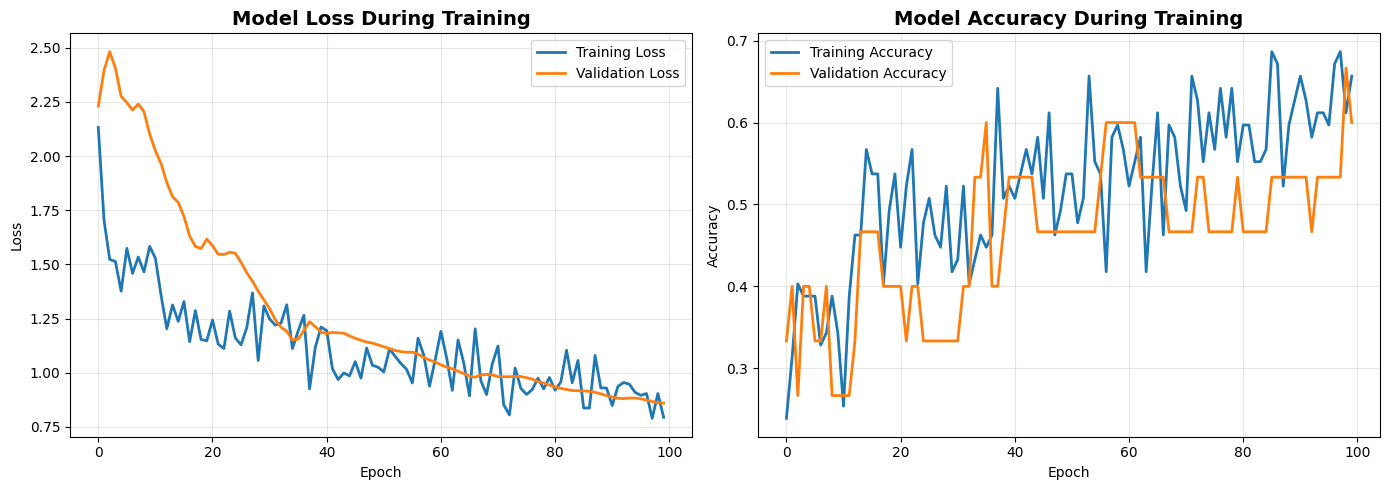

In [11]:
print("\n" + "="*60)
print("VISUALIZING TRAINING PROGRESS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy During Training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Test accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=class_names))


1/1 [==============================] - 0s 138ms/step

Test Loss: 1.0122
Test Accuracy: 0.5333 (53.33%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    car_honk       0.33      0.33      0.33         3
         cat       0.43      0.75      0.55         4
         dog       1.00      0.50      0.67         4
police_siren       0.67      0.50      0.57         4

    accuracy                           0.53        15
   macro avg       0.61      0.52      0.53        15
weighted avg       0.63      0.53      0.54        15



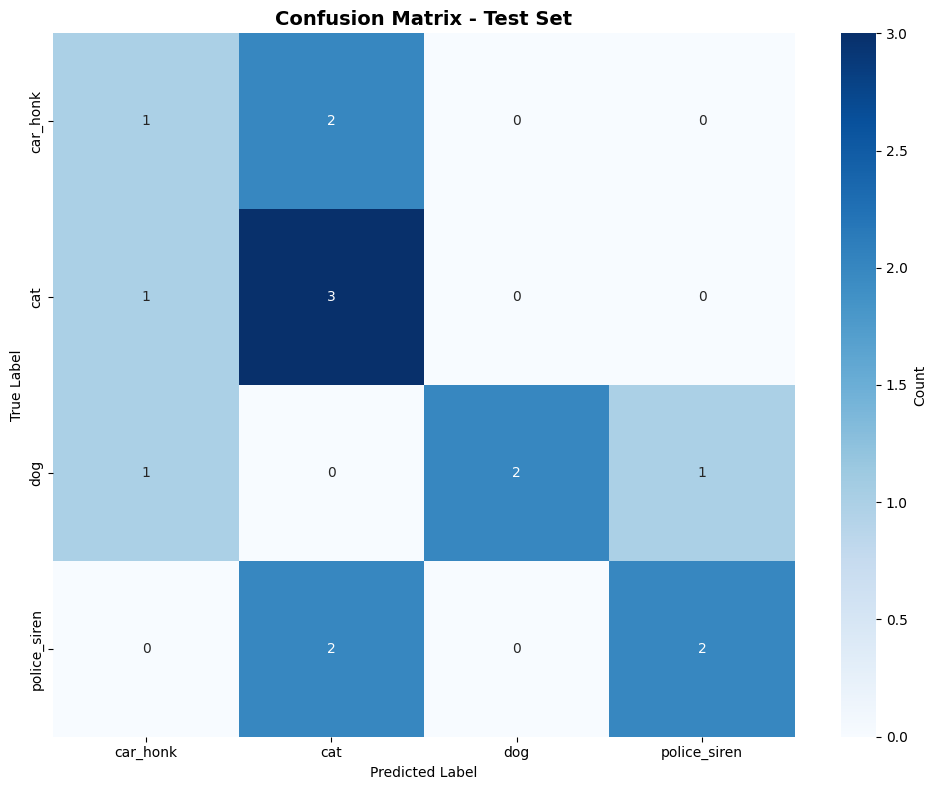

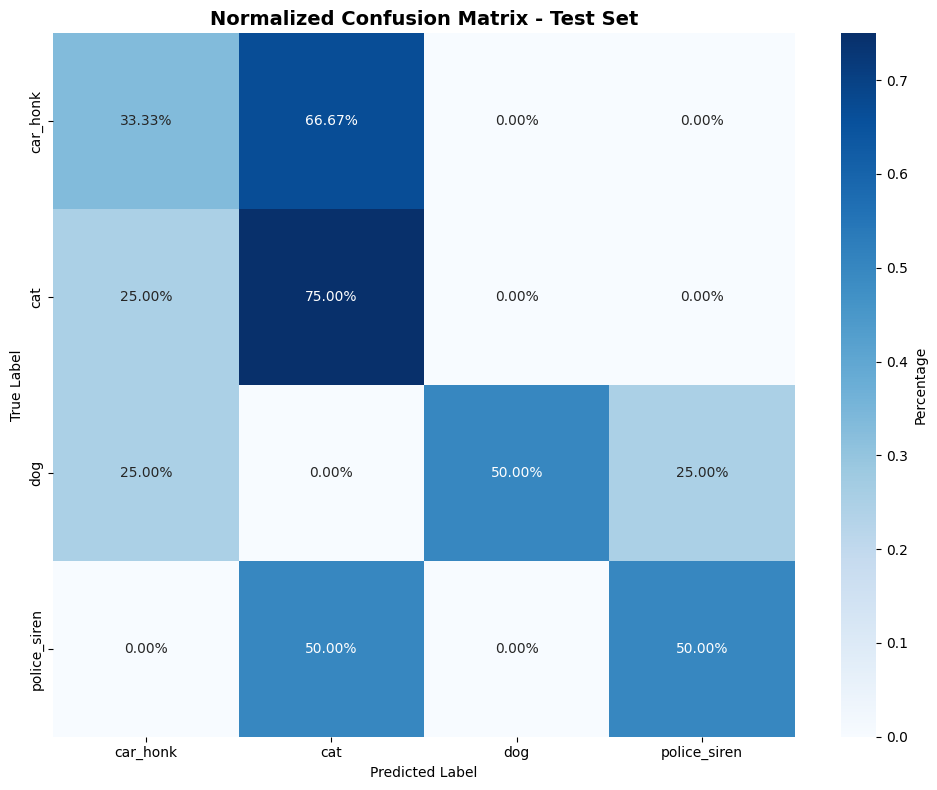

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

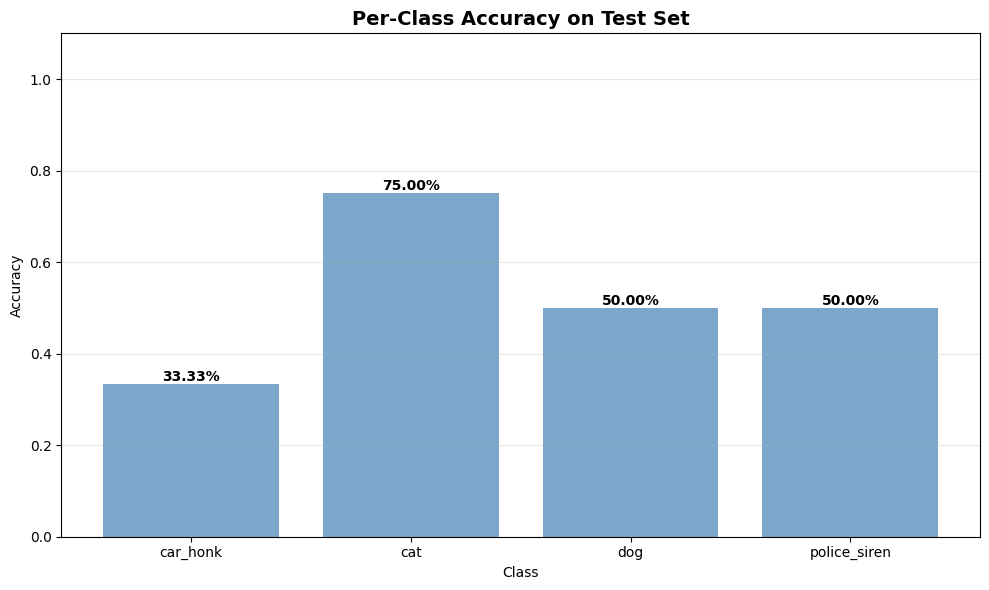

In [14]:
per_class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, per_class_acc, color='steelblue', alpha=0.7)
plt.title('Per-Class Accuracy on Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [15]:
model_metadata = {
    'class_names': class_names,
    'num_classes': num_classes,
    'input_dim': int(embeddings.shape[1]),
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'training_samples': int(len(X_train)),
    'validation_samples': int(len(X_val)),
    'test_samples': int(len(X_test)),
    'per_class_accuracy': {class_names[i]: float(per_class_acc[i]) 
                           for i in range(len(class_names))}
}

with open('../models/finetuned/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)
print(f"\nModel saved to: models/finetuned/")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


MODEL TRAINING COMPLETE!

Model saved to: models/finetuned/
Test Accuracy: 53.33%
